<ipython-input-10-31d747679cfb>:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_categories.index, y=top_categories.values, ax=axes[1], palette='pastel')


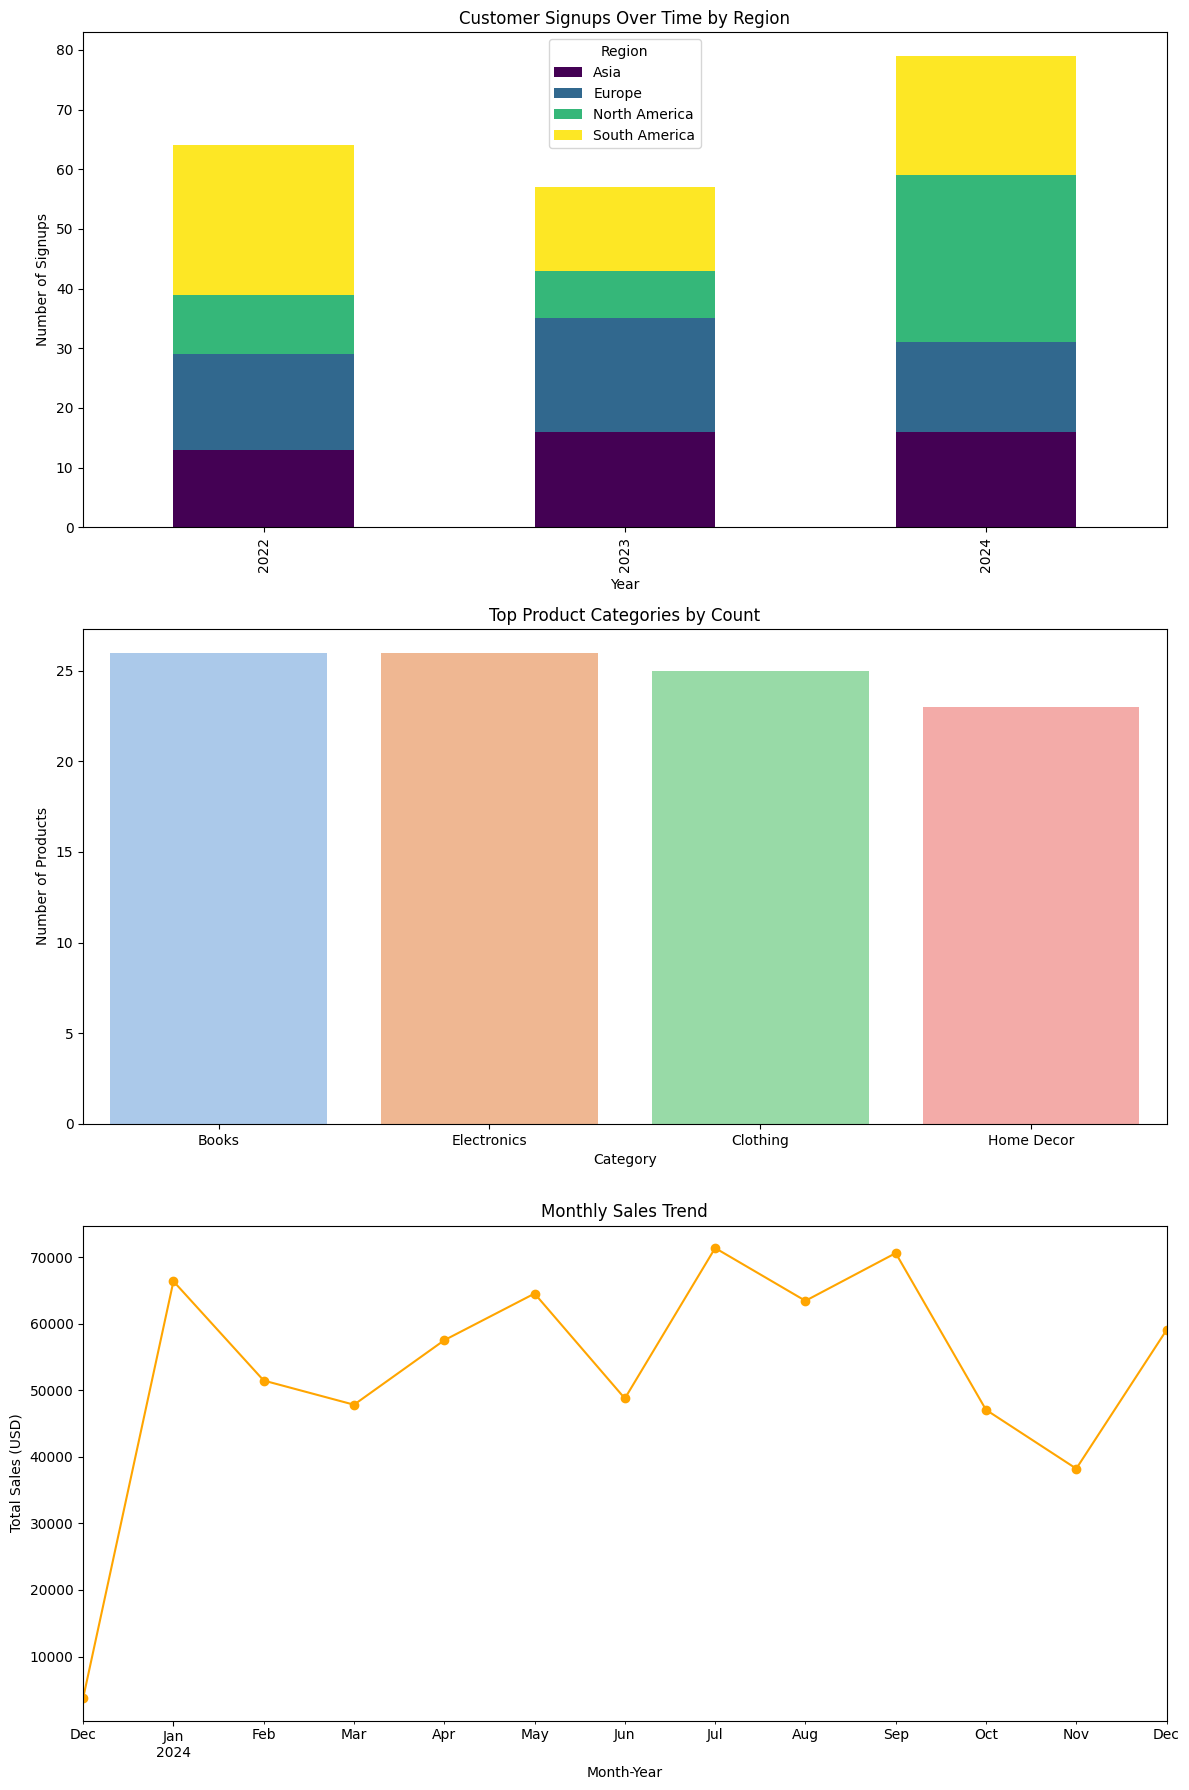

Top Spending Customers:
 CustomerID
C0141    10673.87
C0054     8040.39
C0065     7663.70
C0156     7634.45
C0082     7572.91
C0188     7111.32
C0059     7073.28
C0028     6819.57
C0099     6715.72
C0165     6708.10
Name: TotalValue, dtype: float64
Most Purchased Products:
 ProductID
P059    46
P054    46
P029    45
P079    43
P061    43
P057    43
P048    43
P062    39
P020    38
P028    38
Name: Quantity, dtype: int64


In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

customers = pd.read_csv("Customers.csv")
products = pd.read_csv("Products.csv")
transactions = pd.read_csv("Transactions.csv")

customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])

signup_trends = customers.groupby([customers['SignupDate'].dt.year, 'Region']).size().unstack()

top_categories = products['Category'].value_counts()

transactions['MonthYear'] = transactions['TransactionDate'].dt.to_period('M')
monthly_sales = transactions.groupby('MonthYear')['TotalValue'].sum()

top_spenders = transactions.groupby('CustomerID')['TotalValue'].sum().sort_values(ascending=False).head(10)

most_purchased = transactions.groupby('ProductID')['Quantity'].sum().sort_values(ascending=False).head(10)

fig, axes = plt.subplots(3, 1, figsize=(12, 18))

signup_trends.plot(kind='bar', stacked=True, ax=axes[0], colormap='viridis')
axes[0].set_title('Customer Signups Over Time by Region')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Number of Signups')

sns.barplot(x=top_categories.index, y=top_categories.values, ax=axes[1], palette='pastel')
axes[1].set_title('Top Product Categories by Count')
axes[1].set_xlabel('Category')
axes[1].set_ylabel('Number of Products')

monthly_sales.plot(ax=axes[2], color='orange', marker='o')
axes[2].set_title('Monthly Sales Trend')
axes[2].set_xlabel('Month-Year')
axes[2].set_ylabel('Total Sales (USD)')

plt.tight_layout()
plt.show()

print("Top Spending Customers:\n", top_spenders)
print("Most Purchased Products:\n", most_purchased)


In [ ]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Load the datasets
customers = pd.read_csv("Customers.csv")
products = pd.read_csv("Products.csv")
transactions = pd.read_csv("Transactions.csv")

# Preprocessing and Merging
transactions = transactions.merge(products, on="ProductID", how="left")
transactions = transactions.merge(customers, on="CustomerID", how="left")

# Feature Engineering
customer_features = transactions.groupby("CustomerID").agg(
    total_spending=("TotalValue", "sum"),
    transaction_count=("TransactionID", "count"),
    avg_quantity=("Quantity", "mean"),
    preferred_category=("Category", lambda x: x.mode()[0])
).reset_index()

# One-Hot Encode Preferred Categories
customer_features = pd.get_dummies(customer_features, columns=["preferred_category"], prefix="category")

# Normalize Features
scaler = MinMaxScaler()
numeric_features = ["total_spending", "transaction_count", "avg_quantity"]
customer_features[numeric_features] = scaler.fit_transform(customer_features[numeric_features])

# Calculate Similarities
feature_matrix = customer_features.drop("CustomerID", axis=1)
similarity_matrix = cosine_similarity(feature_matrix)

# Create Recommendations
similarity_df = pd.DataFrame(similarity_matrix, index=customer_features["CustomerID"], columns=customer_features["CustomerID"])
lookalikes = {}

for customer_id in similarity_df.index:
    similar_customers = similarity_df[customer_id].sort_values(ascending=False).iloc[1:4]
    lookalikes[customer_id] = [(idx, round(score, 2)) for idx, score in similar_customers.items()]

# Save Lookalike Recommendations
lookalike_df = pd.DataFrame({"CustomerID": lookalikes.keys(), "SimilarCustomers": lookalikes.values()})
lookalike_df.to_csv("Lookalike.csv", index=False)

print("Lookalike recommendations saved to Lookalike.csv.")


Lookalike recommendations saved to Lookalike.csv.


Accuracy: 0.00


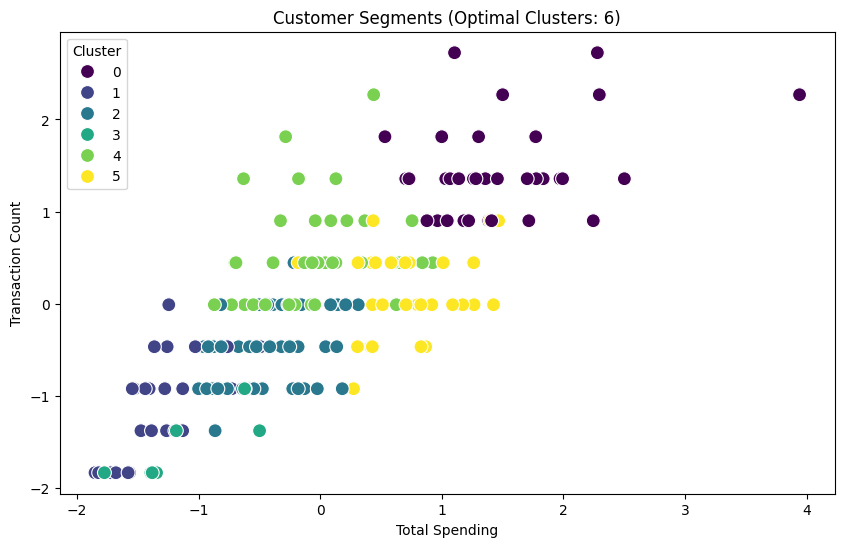

Optimal Number of Clusters: 6
Davies-Bouldin Index: 0.90


In [ ]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Load the datasets
customers = pd.read_csv("Customers.csv")
transactions = pd.read_csv("Transactions.csv")

# Preprocessing and Merging
transactions = transactions.merge(customers, on="CustomerID", how="left")

# Feature Engineering
customer_features = transactions.groupby("CustomerID").agg(
    total_spending=("TotalValue", "sum"),
    transaction_count=("TransactionID", "count"),
    avg_quantity=("Quantity", "mean")
).reset_index()

# Normalize Features
scaler = StandardScaler()
numeric_features = ["total_spending", "transaction_count", "avg_quantity"]
customer_features[numeric_features] = scaler.fit_transform(customer_features[numeric_features])

# Clustering with K-Means
optimal_clusters = 0
lowest_dbi = float("inf")

for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(customer_features[numeric_features])
    dbi = davies_bouldin_score(customer_features[numeric_features], cluster_labels)
    if dbi < lowest_dbi:
        lowest_dbi = dbi
        optimal_clusters = n_clusters

# Fit K-Means with Optimal Clusters
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
customer_features["Cluster"] = kmeans.fit_predict(customer_features[numeric_features])

# Visualization
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=customer_features["total_spending"],
    y=customer_features["transaction_count"],
    hue=customer_features["Cluster"],
    palette="viridis",
    s=100
)
plt.title(f"Customer Segments (Optimal Clusters: {optimal_clusters})")
plt.xlabel("Total Spending")
plt.ylabel("Transaction Count")
plt.legend(title="Cluster")
plt.show()

# Print Results
print(f"Optimal Number of Clusters: {optimal_clusters}")
print(f"Davies-Bouldin Index: {lowest_dbi:.2f}")


In [ ]:
# Running the clustering code to calculate DBI and determine the optimal clusters
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Load the datasets
customers_path = "Customers.csv"
transactions_path = "Transactions.csv"

customers = pd.read_csv(customers_path)
transactions = pd.read_csv(transactions_path)

# Preprocessing and Merging
transactions = transactions.merge(customers, on="CustomerID", how="left")

# Feature Engineering
customer_features = transactions.groupby("CustomerID").agg(
    total_spending=("TotalValue", "sum"),
    transaction_count=("TransactionID", "count"),
    avg_quantity=("Quantity", "mean")
).reset_index()

# Normalize Features
scaler = StandardScaler()
numeric_features = ["total_spending", "transaction_count", "avg_quantity"]
customer_features[numeric_features] = scaler.fit_transform(customer_features[numeric_features])

# Clustering with K-Means
optimal_clusters = 0
lowest_dbi = float("inf")

for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(customer_features[numeric_features])
    dbi = davies_bouldin_score(customer_features[numeric_features], cluster_labels)
    if dbi < lowest_dbi:
        lowest_dbi = dbi
        optimal_clusters = n_clusters

# Final Results
optimal_clusters, lowest_dbi


(6, 0.8969844738833145)